# Robust Successive Projection Algorithm demo

This notebook requires downloading the `f100517t01p00r14rdn_b` AVIRIS scene and unzipping into the `data` subdirectory.

In [12]:
import math
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pysptools.abundance_maps import FCLS
import rasterio as rio
from tqdm.autonotebook import tqdm, trange

from hyperspectral.unmixing import rspa

## Endmember Determination

Start by taking a manageable extract from the source image.

In [2]:
extract_loc = "data/rspa_extract.npz"
if not os.path.exists(extract_loc):
    target_file = 'data/f100517t01p00r14rdn_b/f100517t01p00r14rdn_b_sc01_ort_img'
    with rio.open(target_file) as ds:
        raw = ds.read().astype(np.uint16)
        img = np.dstack(raw[:,list(range(0,ds.shape[0],13)),:].astype(np.float))
        del raw
        img[img > 60000] = 0
    np.savez(extract_loc, img=img)
else:
    img = np.load(extract_loc)['img']
img.shape

(2013, 796, 224)

In [3]:
aviris_wavelengths = list(pd.read_csv('data/f100517t01p00r14rdn_b/f100517t01p00r14rdn_b.spc', sep="\t", header=None, names=['center','fwhm','center_uncertainty','fwhm_uncertainty','channel'])['center'])

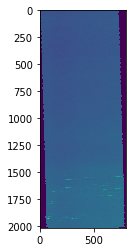

In [3]:
plt.imshow(img[:,:,0])

### RSPA

In [4]:
ems_rspa = rspa(img, 6, 40, β=4.0)

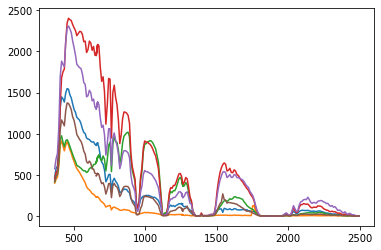

In [27]:
for i in range(len(ems_rspa)):
    plt.plot(aviris_wavelengths, ems_rspa[i])

In [6]:
np.savez('data/rspa_dwh_ems_6.npz', ems=ems_rspa)

### NFINDR

In [5]:
from pysptools.eea import NFINDR

nfindr = NFINDR()
ems_nfindr = nfindr.extract(img, 4, ATGP_init=True)

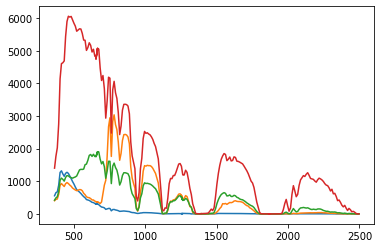

In [7]:
for i in range(len(ems_nfindr)):
    plt.plot(aviris_wavelengths, ems_nfindr[i])

In [7]:
np.savez('data/nfindr_dwh_ems_4.npz', ems=ems_nfindr)

### Compare to a reference spectrum

In [14]:
from scipy.signal import resample
spectrum = []
with open('data/splib07a_Oil_Water_Benzene17_DWH10-3_ASDHRa_AREF.txt', 'r') as f:
    f.readline()
    for line in f.readlines():
        spectrum.append(float(line))
spectrum = np.array(spectrum)
spectrum = spectrum / np.linalg.norm(spectrum, ord=2)
#spectrum_normalized = resample(spectrum, 224) #- spectrum.mean()

In [29]:
reference = pd.concat([
    pd.read_csv('data/splib07a_Wavelengths_ASD_0.35-2.5_microns_2151_ch.txt'),
    pd.read_csv('data/splib07a_Oil_Water_Benzene17_DWH10-3_ASDHRa_AREF.txt')
], axis=1)
reference.columns = ['wavelength', '60:40+Benzene17']
reference

,wavelength,radiance
0,0.350,0.007018
1,0.351,0.007018
2,0.352,0.006482
3,0.353,0.005557
4,0.354,0.005286
...,...,...
2146,2.496,0.045795
2147,2.497,0.045221
2148,2.498,0.044601
2149,2.499,0.045359


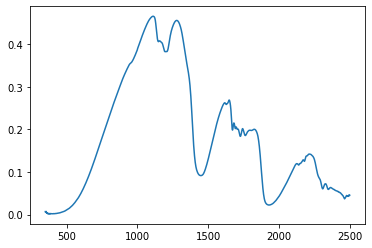

In [33]:
plt.plot(reference['wavelength']*1000, reference['60:40+Benzene17'])

## Abundance Maps

In [28]:
target_file = 'data/f100517t01p00r14rdn_b/f100517t01p00r14rdn_b_sc01_ort_img'

with rio.open(target_file) as ds:
    #w = rio.windows.Window(50,50,512,4096) # Top
    w = rio.windows.Window(120,20000,512,4096) # Bottom

    img = np.dstack(ds.read(window=w).astype(np.uint16).astype(np.float))
    img[img > 60000] = 0

img.shape

(4096, 512, 224)

### RSPA

In [10]:
ems_rspa = np.load('data/rspa_dwh_ems_6.npz')['ems']

In [29]:
fcls = FCLS()
res_rspa = fcls.map(img, ems_rspa)

#### Top of scene

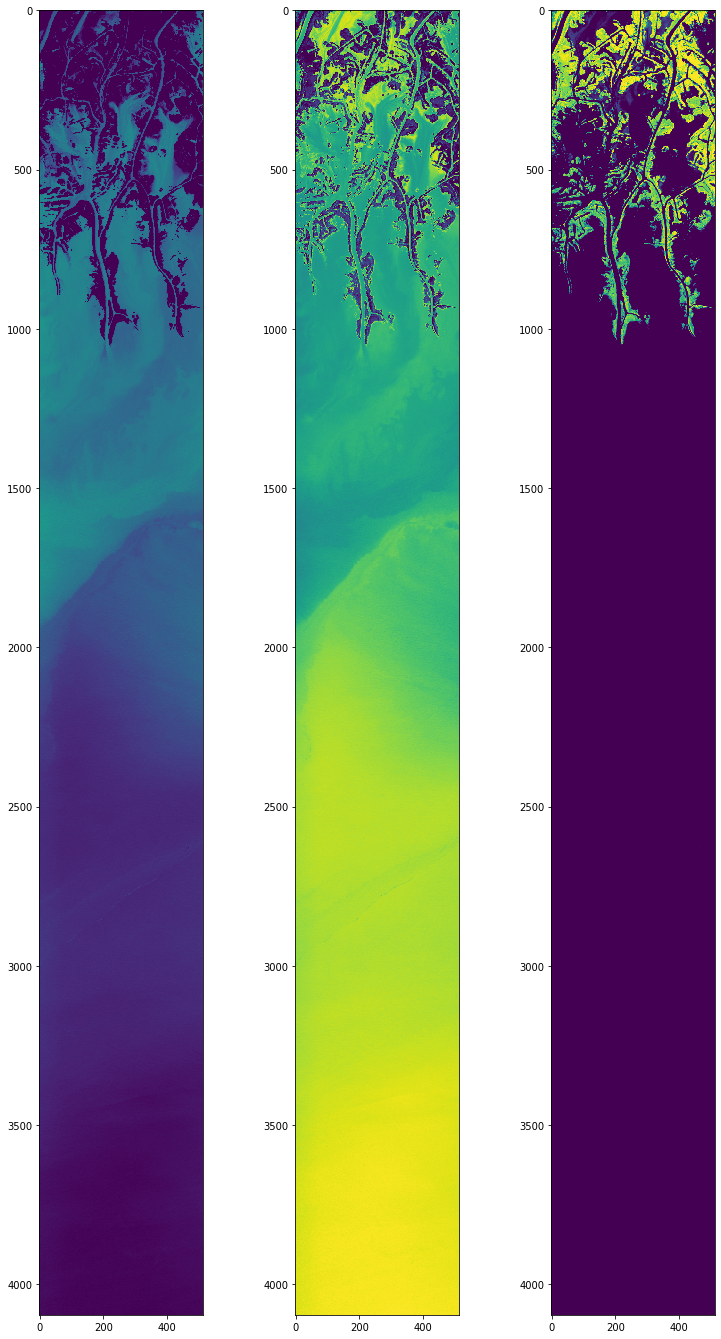

In [25]:
_, ax = plt.subplots(1, 3, figsize=(13,24))
for i in range(3):
    ax[i].imshow(res_rspa[:,:,i],vmax=1)

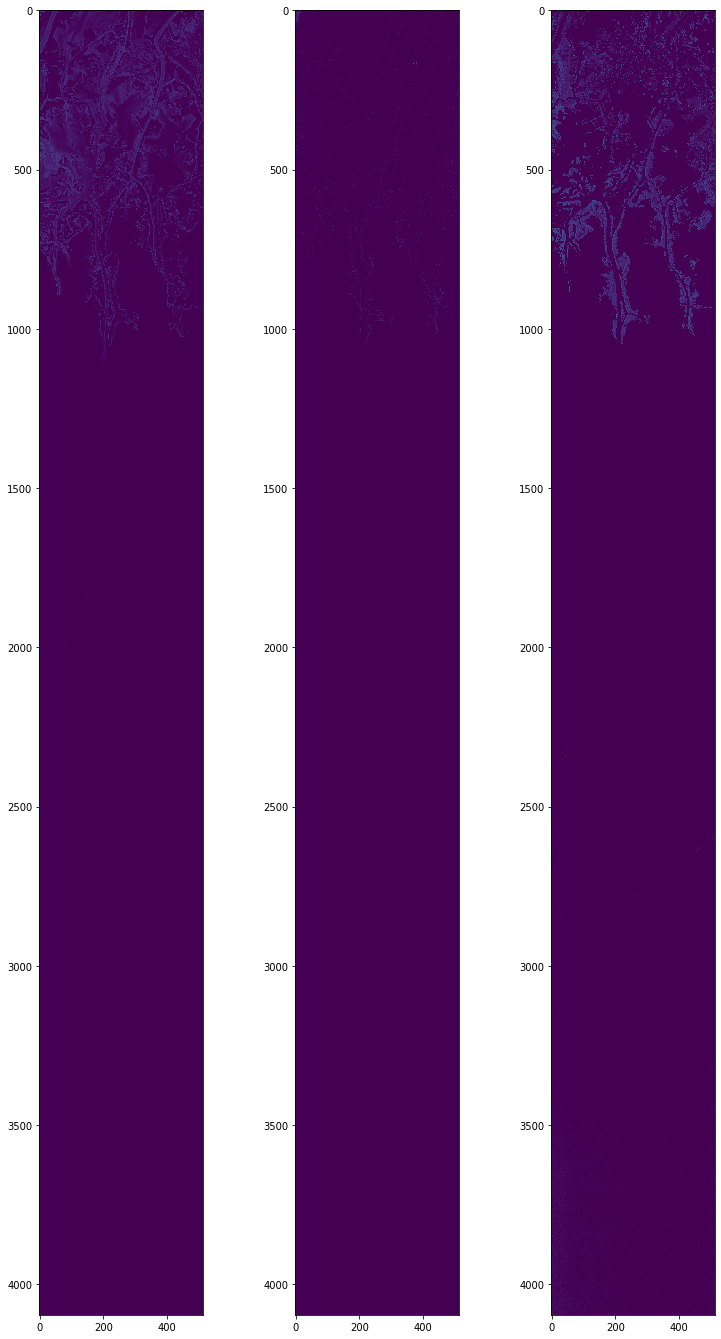

In [26]:
_, ax = plt.subplots(1, 3, figsize=(13,24))
for i in range(3,6):
    ax[i-3].imshow(res_rspa[:,:,i],vmax=1)

#### Bottom of scene

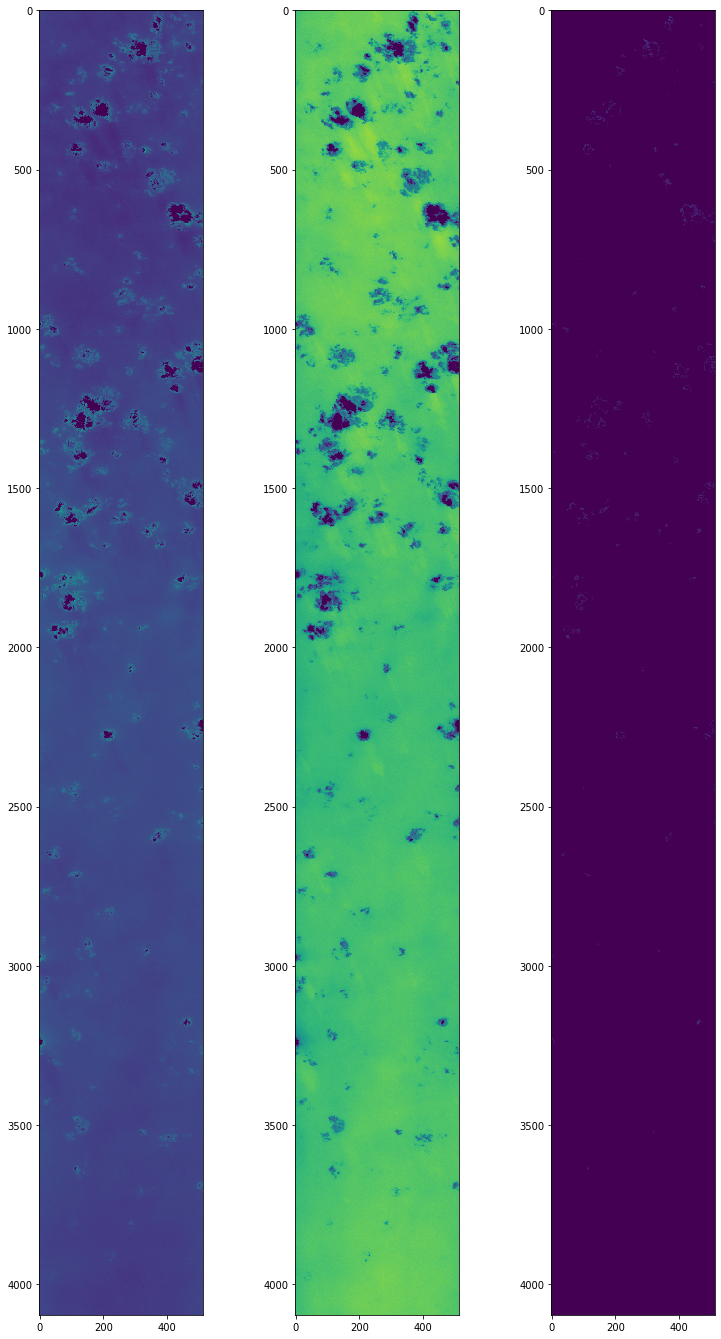

In [30]:
_, ax = plt.subplots(1, 3, figsize=(13,24))
for i in range(3):
    ax[i].imshow(res_rspa[:,:,i],vmax=1)

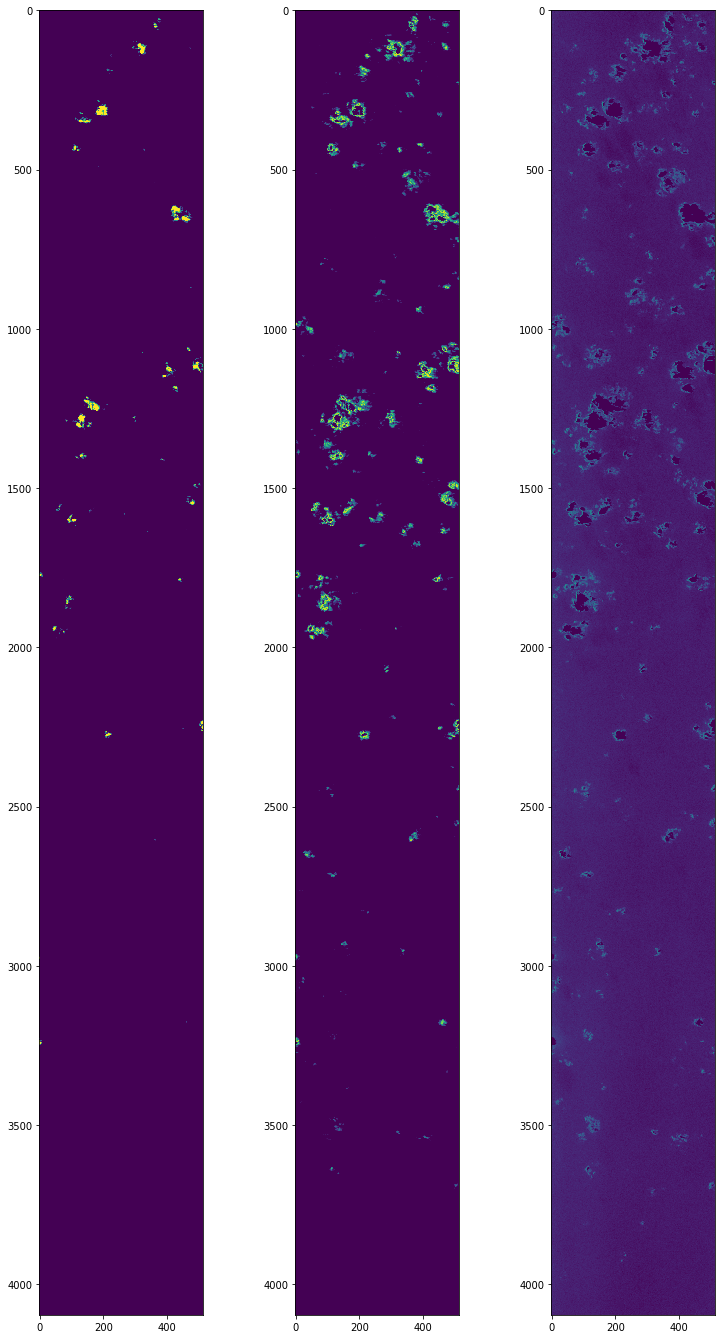

In [31]:
_, ax = plt.subplots(1, 3, figsize=(13,24))
for i in range(3,6):
    ax[i-3].imshow(res_rspa[:,:,i],vmax=1)

### NFINDR

In [5]:
ems_nfindr = np.load('data/nfindr_dwh_ems_4.npz')['ems']

In [6]:
fcls = FCLS()
res_nfindr = fcls.map(img, ems_nfindr)

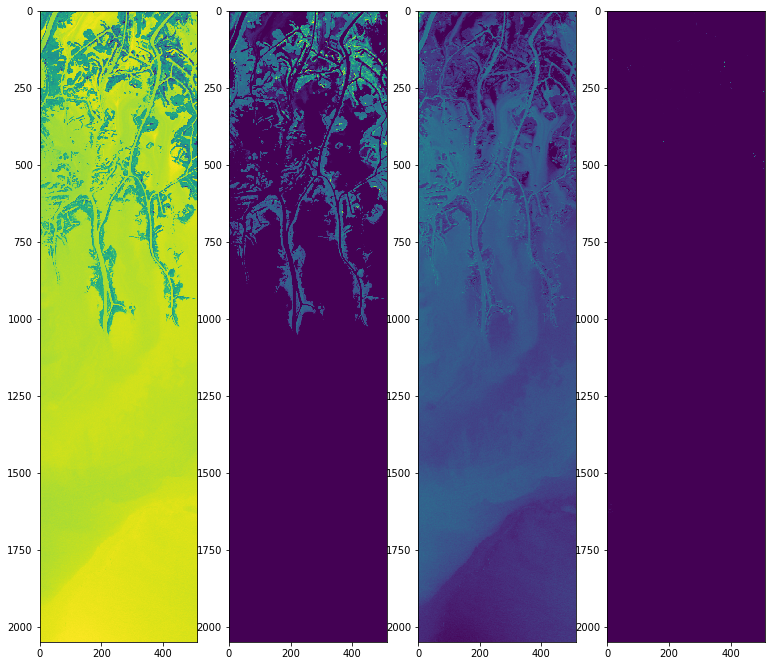

In [7]:
_, ax = plt.subplots(1, 4, figsize=(13,13))
for i in range(4):
    ax[i].imshow(res_nfindr[:,:,i])

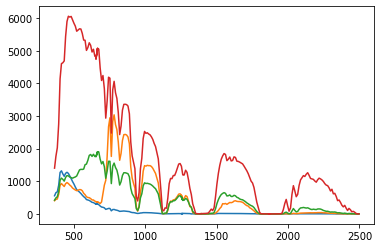

In [36]:
for i in range(len(ems_nfindr)):
    plt.plot(aviris_wavelengths, ems_nfindr[i])